In [1]:
import pandas as pd
import random

file = "Log_Problem.csv"
n = sum(1 for line in open(file)) - 1
s = 810866
skip = sorted(random.sample(range(1,n+1),n-s))
df = pd.read_csv(file, skiprows=skip)

user = pd.read_csv("Info_UserData.csv")
con = pd.read_csv("Info_Content.csv")

user_log = pd.merge(df, user, on='uuid', how='inner', validate="m:1")
full_sample = pd.merge(user_log, con, on="ucid", how="inner", validate="m:1")

In [2]:
full_sample["timestamp_TW"] = pd.to_datetime(full_sample["timestamp_TW"], infer_datetime_format=True)

train = full_sample[full_sample["timestamp_TW"] < "2019-01-01 00:00:00"]
val = full_sample[(full_sample["timestamp_TW"] >= "2019-01-01 00:00:00") & 
                  (full_sample["timestamp_TW"] < "2019-05-01 00:00:00")]
test = full_sample[full_sample["timestamp_TW"] >= "2019-05-01 00:00:00"]

In [3]:
import numpy as np

def wrangle(X):
    
    X = X.copy()
    
    X = X.replace({False : 0, True : 1})
    
    nan_cols = ["is_downgrade"]
    for col in nan_cols:
        X[col] = X[col].replace(np.nan, 0)
        
# This chunk of code is derived from the permutation_importance done below. There are approximately 3-4 valuable features
# in this DF, so all but those few will be dropped.
    
    star_features = ["total_attempt_cnt", "used_hint_cnt", "badges_cnt",
                     "points", "is_downgrade", "is_correct"]
    X = X[star_features]
    
    return X

train2 = wrangle(train)
val2 = wrangle(val)
test2 = wrangle(test)

target = "is_correct"

X_train2 = train2.drop([target], axis=1)
y_train2 = train2[target]
X_val2 = val2.drop([target], axis=1)
y_val2 = val2[target]
X_test2 = test2.drop([target], axis=1)

In [4]:
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier


rick = make_pipeline(
    ce.TargetEncoder(),
    SimpleImputer(strategy="most_frequent"),
    StandardScaler(),
    RandomForestClassifier(max_depth=25, criterion="entropy",
                           n_jobs=1, random_state=45,
                           min_samples_split=25))

rick.fit(X_train2, y_train2);

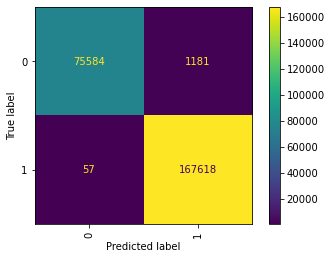

In [5]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(rick, X_val2, y_val2,
                      values_format='.0f', xticks_rotation='vertical');

Text(0, 0.5, 'True Positive Rate')

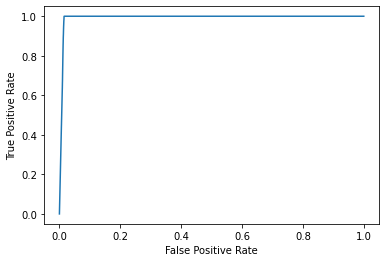

In [6]:
%matplotlib inline

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

y_p_p = rick.predict_proba(X_val2)[:, -1]
fpr3, tpr3, thresholds3 = roc_curve(y_val2, y_p_p)

plt.plot(fpr3, tpr3)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

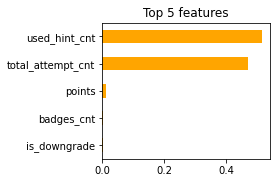

In [7]:
search_feature = rick.named_steps["randomforestclassifier"]
importances = pd.Series(search_feature.feature_importances_, X_train2.columns)

n = 5
plt.figure(figsize=(3,n/2))
plt.title(f"Top {n} features")
importances.sort_values()[-n:].plot.barh(color="orange");